In [19]:
import numpy as np
import itertools
from amplify import gen_symbols, BinaryPoly, sum_poly, Solver, decode_solution
from amplify.constraint import penalty, less_equal
from amplify.client import FixstarsClient
debug = False
weight = 10


In [20]:
#---------------------------------------
# 定数の定義
#---------------------------------------

# 床の寸法(cm)
# floor_org = [  2,   3]  # for テスト(紙が余る)
# floor_org = [  2,   4]  # for テスト(ピッタリ)
# floor_org = [  2,   5]  # for テスト(紙が足りない)
# floor_org = [ 12,  12]  # for 提出用1
floor_org = [  9,  16]  # for 提出用2
# floor_org = [  7,  20]  # for 提出用3

# 利用可能な紙の種類と寸法(cm)
# paper_org = [[ 1,  2]]  # for テスト
paper_org = [[ 3,  4], [ 2,  3], [ 5,  1]]  # for 提出用

# 利用可能な紙の枚数(種類毎)
# paper_num = 2       # for テスト
paper_num = 3       # for 提出用

# デバッグ表示
print('floor = {} : papers = {} x 2 x {}'.format(floor_org, paper_org, paper_num, ))


floor = [9, 16] : papers = [[3, 4], [2, 3], [5, 1]] x 2 x 3


In [21]:
#---------------------------------------
# 決定変数の定義
#---------------------------------------

# 紙の向きを考慮に入れる(縦横を入れ替えたサイズを追記)
paper = paper_org + [[paper_org[i][1], paper_org[i][0]] for i in range(len(paper_org))]

# 紙の総枚数
paper_total_num = len(paper) * paper_num

# 床の寸法
floor_v = int(floor_org[0])
floor_h = int(floor_org[1])

# ゼロに制約を掛けるバイナリ変数を覚えるための変数
start = 0
q_zero = gen_symbols(BinaryPoly, start, (1,))

# 「紙の種類」と「紙の頂点位置」を示すバイナリ変数を生成
start += 1
q_paper = gen_symbols(BinaryPoly, start, (paper_total_num, floor_v, floor_h))

# 床の重なりを管理するための配列
# 配列の作り方がよく分からないのでバイナリ変数の配列を定義して
# 中身は使わない（ゼロ制約の変数に足し込む）
start += paper_total_num * floor_v * floor_h
q_floor = gen_symbols(BinaryPoly, start, (floor_v, floor_h))
for i, j in itertools.product(range(floor_v), range(floor_h)):
    q_zero[0] += q_floor[i][j]


In [22]:
#---------------------------------------
# 制約条件の定義(1)：紙は重ならない
#---------------------------------------

# 「紙の頂点位置」に対する「床の占有領域」を紐付ける
for i in range(paper_total_num):
    print('\rCollecting Q-bits from papers overlapping on floor {}/{} ... '.format(i + 1, paper_total_num), end='', flush=True)

    # 紙のサイズを取得
    p_size_v, p_size_h = paper[i % len(paper)][0], paper[i % len(paper)][1]
    # print(p_size_v, p_size_h)

    # 重なる紙の位置を集める
    for p_v, p_h in itertools.product(range(floor_v), range(floor_h)):

        # 床に紙を置くスペースが無い場合はスキップ（ゼロ制約の変数に足し込む）
        if (p_v + p_size_v > floor_v) or (p_h + p_size_h > floor_h):
            # print('skip:({} x {} = {})'.format(p_v, p_h, q_paper[i][p_v][p_h]))
            q_zero[0] += q_paper[i][p_v][p_h]
            continue
        
        # 紙の面積に相当する部分の床に記録する
        for f_v, f_h in itertools.product(range(p_v, p_v + p_size_v), range(p_h, p_h + p_size_h)):
            q_floor[f_v][f_h] += q_paper[i][p_v][p_h]
            # print('add:(paper {} x {} = {}) -> (floor {} x {} = {})'.format(p_v, p_h, q_paper[i][p_v][p_h], f_v, f_h, q_floor[f_v][f_h]))

print('done.')

# 上で集めた床を共有する紙の位置にless_equal制約（1以下）を掛ける
g_overlap = 0
g_floor = 0
print('Calculating penalty for floor ... ', end='', flush=True)
for f_v, f_h in itertools.product(range(floor_v), range(floor_h)):
    g_floor = less_equal(q_floor[f_v][f_h], 1)
    g_overlap += g_floor
print('done.')
# print(g_overlap)


Calculating penalty for floor ... done.


In [23]:
#---------------------------------------
# 制約条件の定義(2)：紙は最大で一カ所しか置けない
#---------------------------------------

# 「紙の種類」と「紙の頂点位置」を示すバイナリ変数にless_equal制約（1以下）を掛ける
g_use = 0
print('Calculating penalty for papers ... ', end='', flush=True)
for i in range(paper_total_num):

    # 紙のサイズを取得
    p_size_v, p_size_h = paper[i % len(paper)][0], paper[i % len(paper)][1]
    # print(p_size_v, p_size_h)
    g_paper = 0

    # この紙が持つバイナリ変数が制約の対象
    for p_v, p_h in itertools.product(range(floor_v), range(floor_h)):

        # 床に紙を置くスペースが無い場合はスキップ
        if (p_v + p_size_v > floor_v) or (p_h + p_size_h > floor_h):
            # print('skip:({} x {} = {})'.format(p_v, p_h, q_paper[i][p_v][p_h]))
            # q_zero[0] += q_paper[i][p_v][p_h]
            continue

        # この紙の頂点の位置を集める
        g_paper += q_paper[i][p_v][p_h]

    g_use += less_equal(g_paper, 1)
    # print('(g_paper {} = {}))'.format(i, g_paper))

print('done.')
# print(g_use)


Calculating penalty for papers ... done.


In [24]:
#---------------------------------------
# 目的関数：
#---------------------------------------

# 全ての紙の面積を求める
all_p_area = 0
for i in range(paper_total_num):
    print('\rMaking objective function {}/{} ... '.format(i + 1, paper_total_num), end='', flush=True)

    # 紙のサイズを取得する
    p_size_v, p_size_h = paper[i % len(paper)][0], paper[i % len(paper)][1]
    
    # 紙の面積を計算する
    p_area = 0
    for p_v, p_h in itertools.product(range(floor_v), range(floor_h)):

        # 紙を置くスペースが無い場合はスキップ
        if (p_v + p_size_v > floor_v) or (p_h + p_size_h > floor_h):
            # print('skip:({} x {} = {})'.format(p_v, p_h, q_paper[i][p_v][p_h]))
            # q_zero[0] += q_paper[i][p_v][p_h]
            continue
        
        p_area += q_paper[i][p_v][p_h]
    
    p_area = (p_area) * (p_size_v * p_size_h)
    # print('(p_area = {}))'.format(p_area))

    # 全ての紙の面積を求める
    all_p_area += p_area

# 床の面積から紙の面積を引いたものを最小化する
objective = ((floor_v * floor_h) - all_p_area) ** 2
print('done.')
# print(objective)


Making objective function 18/18 ... done.


In [29]:
#---------------------------------------
# ソルバーを設定して解く
#---------------------------------------

# クライアント設定
client = FixstarsClient()
client.url = "http://optigan.fixstars.com"
client.parameters.timeout = 60000
client.token = "xxxxxxxxxxxxxxxxxxxxxxxxxxx"
client.parameters.outputs.duplicate = False
client.parameters.outputs.num_outputs = 1

# ソルバーを設定
solver = Solver(client)
# solver.filter_solution = False

# 使わない量子ビットにゼロ制約を掛ける
g_zero = penalty(sum_poly(q_zero))
# print(g_zero)

# モデルを作る
# model = objective + (g_overlap * weight) + (g_use * weight) + (g_zero * weight)
model = objective + (g_overlap * weight) + (g_use * weight)

print('Solving by the Fixstars! ... ', end='', flush=True)
result = solver.solve(model)
print('done.')
print('{} result(s) was found.'.format(len(result)))


Solving by the Fixstars! ... done.
1 result(s) was found.


In [30]:
#---------------------------------------
# 解の確認
#---------------------------------------
for sol in result:
    if debug:
        energy = sol.energy
        values = sol.values
        print(f"energy = {sol.energy}, {q_paper} = {decode_solution(q_paper, sol.values)}")
        # print(model.check_constraints(sol.values))
    else:
        energy = sol.energy
        print(f"energy = {sol.energy}")
    break


energy = 36.0


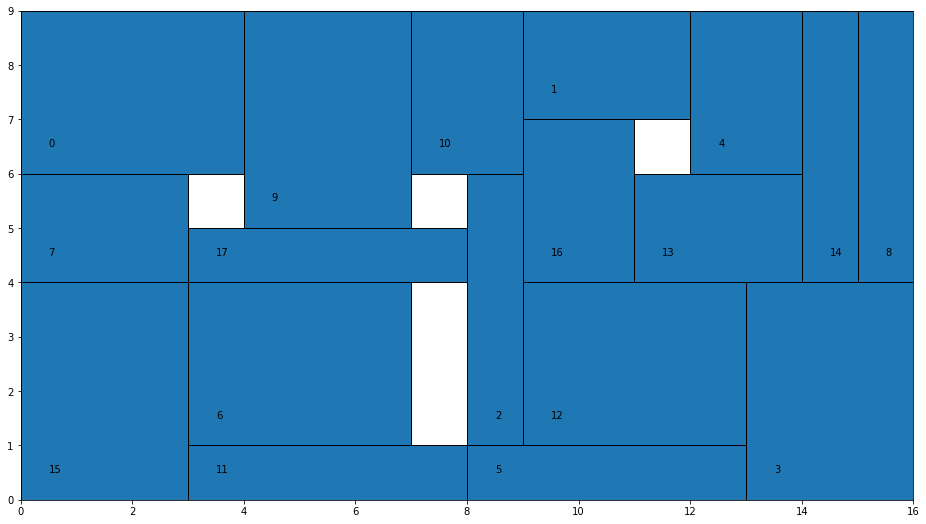

In [31]:
#---------------------------------------
# 図の作成
#---------------------------------------
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 計算結果を取得
a_paper = decode_solution(q_paper, sol.values)

# 床を描画
fig = plt.figure(figsize=(floor_h, floor_v))
ax = plt.axes()
ax.set_ylim(0, floor_v)
ax.set_xlim(0, floor_h)

# 紙を描画
for i in range(paper_total_num):
    for p_v, p_h in itertools.product(range(floor_v), range(floor_h)):
        if a_paper[i][p_v][p_h] == 1:
            p_size_v, p_size_h = paper[i % len(paper)][0], paper[i % len(paper)][1]
            r = patches.Rectangle(xy=(p_h, p_v), width=p_size_h, height=p_size_v, ec='#000000', fill=True)
            plt.text(p_h+0.5, p_v+0.5, str(i))
            ax.add_patch(r)
            break

plt.show()

# 画像を保存する
figname = './' + str(floor_org[0]) + 'x' + str(floor_org[1])
fig.savefig(figname + ".png")
